## Ingesting & Environment Setup

In [1]:
import pandas as pd
import numpy as np
import os
import re
import torch
import torch.nn as nn
from tqdm import tqdm
from PIL import Image
from torch.utils.data import random_split, DataLoader, Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

c:\Users\Aziz\miniconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Read csv file
df = pd.read_csv('../data/fusion_cleaned_dataset.csv', sep=',')
df.sample(2)

,username,id,caption,Fashion and Style,Food and Dining,Family and Relationships,Sports and Fitness,Entertainment,Business and Industry,Travel and Adventure,Arts and Culture,News,Pets,Technology and Gadgets
15740,columbiagsapp,18179664283216087,the msred hospitality club recently organized ...,0,0,0,0,0,0,0,1,0,0,0
13888,yamashitaphoto,18014727637460769,wuqiao county in the southeast of hebei provin...,0,1,0,0,0,0,1,1,0,0,0


In [3]:
import torch.nn as nn
import torch.hub

class Model(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(Model, self).__init__()
        self.model = torch.hub.load(
            'pytorch/vision:v0.9.0', 'vgg11', weights=pretrained)
        self.model.classifier[6] = torch.nn.Linear(
            self.model.classifier[6].in_features, num_classes)
        self.model.fc = self.model.classifier[6]

    def forward(self, x):
        x = self.model(x)
        return x

In [4]:
# Load the models that we will use for the fusion using ANN
cnn_model_ = torch.load('../artifacts/cnn_instagram.pt', map_location=device)

# preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: transforms.functional.to_pil_image(x).convert('RGBA') if x.shape[0] == 4 else transforms.functional.to_pil_image(x)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [5]:
all_interests= [
    'Fashion and Style',
    'Food and Dining',
    'Family and Relationships',
    'Sports and Fitness',
    'Entertainment',
    'Business and Industry',
    'Travel and Adventure',
    'Arts and Culture',
    'News',
    'Pets',
    'Technology and Gadgets'
]

def generate_training_data(df, ids, masks, tokenizer):
    for i, text in tqdm(enumerate(df['caption']), total=len(df), desc='Generating training data', ncols=100):
        tokenized_text = tokenizer.encode_plus(
            text,
            max_length=256, 
            truncation=True, 
            padding='max_length', 
            add_special_tokens=True,
            return_tensors='tf'
        )
        ids[i, :] = tokenized_text.input_ids
        masks[i, :] = tokenized_text.attention_mask
    return ids, masks

def clean_text(text):
    text = text.lower()
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    text = re.sub(r'[^A-Za-z0-9 ]+', '', text)
    # remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def prepare_data(input_text, tokenizer):
    input_text = clean_text(input_text)
    token = tokenizer.encode_plus(
        input_text,
        max_length=256, 
        truncation=True, 
        padding='max_length', 
        add_special_tokens=True,
        return_tensors='tf'
    )
    return {
        'input_ids': token.input_ids,
        'attention_mask': token.attention_mask,
    }

def make_prediction(model, processed_data, classes=all_interests):
    probs = model.predict(processed_data)[0]
    threshold = 0.1
    # Return a pandas series of interests with probability greater than threshold
    return pd.Series(data=probs, index=classes)[lambda x: x > threshold].sort_values(ascending=False)

# Define the custom layer
class CustomTFBertMainLayer(tf.keras.layers.Layer):
    def __init__(self, *args, **kwargs):
        super(CustomTFBertMainLayer, self).__init__(*args, **kwargs)

    def call(self, inputs, **kwargs):
        # Implement the custom layer logic here
        pass

# Register the custom layer
tf.keras.utils.get_custom_objects()['CustomTFBertMainLayer'] = CustomTFBertMainLayer

# Load the BERT model
with tf.keras.utils.custom_object_scope({'CustomTFBertMainLayer': CustomTFBertMainLayer}):
    interest_model = tf.keras.models.load_model('../artifacts/bert_interest_model.h5')

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [6]:
X_input_ids = np.zeros((len(df), 256))
X_attn_masks = np.zeros((len(df), 256))
X_input_ids, X_attn_masks = generate_training_data(df, X_input_ids, X_attn_masks, tokenizer)

Generating training data: 100%|██████████████████████████████| 22230/22230 [00:32<00:00, 685.49it/s]


In [12]:
# from torchvision.datasets import ImageFolder
# import shutil

# def create_dummy_folder(labels, folder_path):
#     # Create the dummy folder
#     os.makedirs(folder_path, exist_ok=True)
    
#     # Create subfolders for each label
#     for label in labels:
#         subfolder_path = os.path.join(folder_path, label)
#         os.makedirs(subfolder_path, exist_ok=True)

# def delete_dummy_folder(folder_path):
#     # Delete the entire dummy folder
#     if os.path.exists(folder_path):
#         # Delete the entire directory tree
#         shutil.rmtree(folder_path)


# def get_default_label_order(labels):
#     dummy_folder_path = './temmp'  # Replace with the desired dummy folder path
#     create_dummy_folder(labels, dummy_folder_path)
#     label_order = sorted(os.listdir(dummy_folder_path))
#     delete_dummy_folder(dummy_folder_path)
#     return label_order

# cnn_label_mapper = get_default_label_order(all_interests)

cnn_label_mapper = [
    'Arts and Culture',
 'Entertainment',
 'Family and Relationships',
 'Fashion and Style',
 'Food and Dining',
 'News',
 'Pets',
 'Sports and Fitness',
 'Technology and Gadgets',
 'Travel and Adventure',
 'Business and Industry'
]
all_interests_idx = [all_interests.index(label) for label in cnn_label_mapper]


In [8]:
cnn_model = Model(len(all_interests))
cnn_model.load_state_dict(cnn_model_)
cnn_model = cnn_model.to(device)
cnn_model.eval()  # Set the model to evaluation mode

Using cache found in C:\Users\Aziz/.cache\torch\hub\pytorch_vision_v0.9.0
c:\Users\Aziz\miniconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model(
  (model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (12): ReLU(inplace=True)
      (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (14): ReLU(inplace=True)
      (15): MaxPool2d(kernel_size=2,

In [24]:
# Now we need to match, the posts with their images, using the username and the post id. ../data/images/username/post_id.jpg
# We will need to make a custom data loader, that uses the dataset we have to load the images and the text,
# Then we will need to plug the text into the BERT model, and the images into the CNN model, and then we will need to fuse the results
# into a single vector, and then we will need to use that vector to train a new model, that will be used for the final prediction

class CustomDataset(Dataset):
    def __init__(self, df, image_folder, tokenizer, transform):
        self.df = df
        self.image_folder = image_folder
        self.tokenizer = tokenizer
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        username = self.df.iloc[idx]['username']
        post_id = self.df.iloc[idx]['id']
        caption = self.df.iloc[idx]['caption']
        image_path = os.path.join(self.image_folder, f'{username}/{post_id}.jpg')

        # Load and preprocess image
        image = Image.open(image_path).convert('RGB')
        image = self.transform(image)

         # Convert image to PyTorch tensor
        image = torch.tensor(np.array(image))

        interests = self.df.iloc[idx][-len(all_interests):].values.tolist()

        # Convert interests to tensor
        interests_tensor = torch.tensor(interests)

        # Prepare text data
        processed_data = {
          'input_ids': X_input_ids[idx],
          'attention_mask': X_attn_masks[idx],
        }
        return image, processed_data, interests_tensor

In [25]:
# Define your image folder path
image_folder = '../data/images'

# Create custom dataset
dataset = CustomDataset(df, image_folder, tokenizer, transform)

# Define a batch size for data loading
batch_size = 16

# Create data loader
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

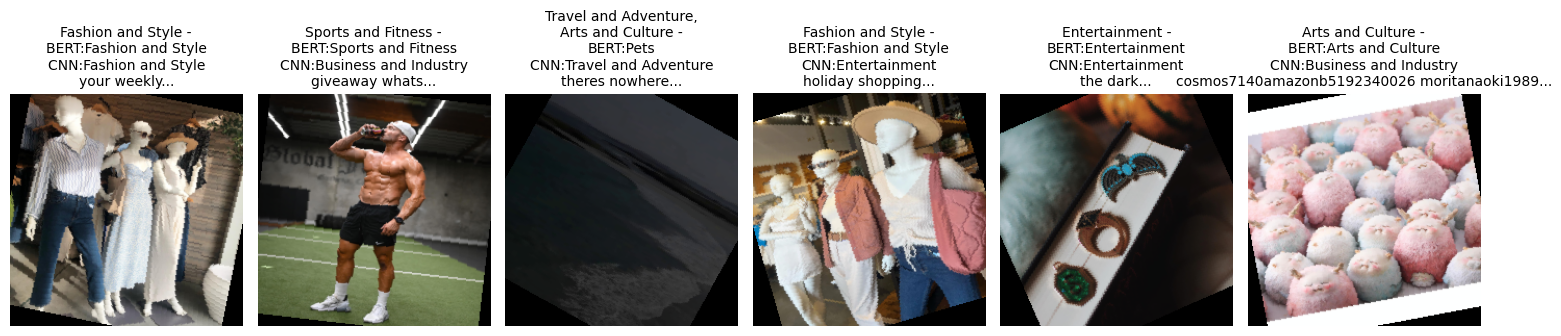

In [41]:
import random
import matplotlib.pyplot as plt

# Set the number of posts to display
num_posts = 6

# Get random indices
random_indices = random.sample(range(len(dataset)), num_posts)

# Plot the random posts
fig, axes = plt.subplots(nrows=1, ncols=num_posts, figsize=(15, 5))

for i, idx in enumerate(random_indices):
    image, processed_data, labels = dataset[idx]
    cnn_image = image.unsqueeze(0).to(device)
    image = image.cpu().numpy().transpose((1, 2, 0))
    image = (image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])).clip(0, 1)  # Undo normalization

    # Display the image
    axes[i].imshow(image)
    axes[i].axis('off')

    # Get BERT predictions
    text_inputs = {
        'input_ids': np.array([processed_data['input_ids']]),
        'attention_mask': np.array([processed_data['attention_mask']])
    }
    bert_output = interest_model(text_inputs)
    bert_output = bert_output.cpu().numpy().squeeze()
    bert_label = all_interests[np.argmax(bert_output)]

    # Get CNN predictions
    with torch.no_grad():
        cnn_preds = cnn_model(cnn_image)
        _, predicted_labels = torch.max(cnn_preds, 1)
        predicted_labels = predicted_labels.cpu().numpy()
        
    cnn_label = cnn_label_mapper[predicted_labels[0]]

    # Use the Fusion Model
    FusionModel = FusionModel(interest_model, cnn_model)
    

    # Get the original text
    original_text = df.iloc[idx]['caption']

    # Interests, take the ones which are equal to 1
    interests = df.iloc[idx][all_interests].loc[lambda x: x == 1].index.tolist()
    interests = ',\n'.join(interests)

    # Display the text
    axes[i].set_title(f'{interests} -\nBERT:{bert_label}\nCNN:{cnn_label}\n{" ".join(original_text.split(" ")[:2])}...', fontsize=10)

plt.tight_layout()
plt.show()

In [13]:
# Fusion model
class FusionModel(nn.Module):
    def __init__(self, bert_model, cnn_model, num_interests):
        super(FusionModel, self).__init__()
        self.bert_model = bert_model
        self.cnn_model = cnn_model
        

    def predict(self, image_inputs, text_inputs):
        # Get BERT predictions
        text_inputs = {
            'input_ids': np.array([processed_data['input_ids']]),
            'attention_mask': np.array([processed_data['attention_mask']])
        }
        bert_output = interest_model(text_inputs)
        bert_output = bert_output.cpu().numpy().squeeze()

        # Get CNN predictions
        with torch.no_grad():
            cnn_preds = cnn_model(image_inputs)
            _, predicted_labels = torch.max(cnn_preds, 1)
            predicted_labels = predicted_labels.cpu().numpy()
            
        # Use all_interests_idx to reorder the predictions
        cnn_preds = cnn_preds.cpu().numpy().squeeze()[all_interests_idx]

        # Get the fusion vector (MAX)
        fusion_vector = np.maximum(bert_output, cnn_preds)

        # Our vector is 2D
        return fusion_vector > 0.5

        

In [ ]:
# Create fusion model
fusion_model = FusionModel(interest_model, cnn_model, num_classes=len(all_interests))

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
fusion_model.train()

optimizer = torch.optim.Adam(fusion_model.parameters(), lr=0.001)

In [ ]:
from tqdm import tqdm

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    fusion_model.train()
    running_loss = 0.0

    # Use tqdm to track the progress
    data_loader_with_progress = tqdm(data_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for images, texts, labels in data_loader_with_progress:
        images = images.to(device)

        optimizer.zero_grad()

        outputs = fusion_model(images, texts)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Update the tqdm progress bar
        data_loader_with_progress.set_postfix({"Loss": loss.item()})

    epoch_loss = running_loss / len(data_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")